<a href="https://colab.research.google.com/github/vasugupta9/DeepLearningProjects/blob/main/StreetViewHouseNumbers_Classifier/Colab_ImageClassifier_SVHN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This project is an Image Classifier for the Street View House Numbers (SVHN) Dataset obtained from house numbers in Google Street View images.

- Libaries used include tensorflow 2.x, keras, numpy, etc

In [1]:
# importing libraries
import tensorflow as tf
from scipy.io import loadmat

# importing additional required libraries 
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Downloading the SVHN dataset from http://ufldl.stanford.edu/housenumbers/ (Dataset Format 2: Cropped Digits is used)
if not os.path.exists('train_32x32.mat') :
  print("Downloading SVHN training dataset")
  !wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat 
else :
  print("SVHN training dataset 'train_32x32.mat' already exists in current working folder")

if not os.path.exists('test_32x32.mat') :
  print("Downloading SVHN testing dataset")
  !wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat 
else :
  print("SVHN testing dataset 'test_32x32.mat' already exists in current working folder")


--2020-11-04 09:18:13--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  8.77MB/s    in 16s     

2020-11-04 09:18:29 (10.8 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2020-11-04 09:18:29--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  12.5MB/s    in 5.0s    

2020-11-04 09:18:34 (12.3 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [3]:
# loading the train and test dataset 
train = loadmat('train_32x32.mat')
test  = loadmat('test_32x32.mat')

In [4]:
print(type(train), type(test))
print(train.keys())
print(test.keys())

<class 'dict'> <class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


In [5]:
# Extracting the images and labels
train_X = train['X']
train_y = train['y']
test_X  = test["X"]
test_y  = test["y"]

print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(32, 32, 3, 73257) (73257, 1)
(32, 32, 3, 26032) (26032, 1)


In [6]:
# converting the train_X, test_X arrays to have the (number of samples) dimension as the first dimension 
train_X = np.moveaxis(train_X, -1, 0)
test_X = np.moveaxis(test_X, -1, 0)
print(train_X.shape)
print(test_X.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


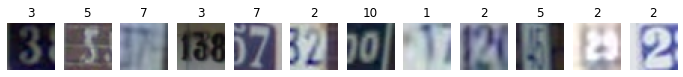

In [7]:
# Displaying sample images and corresponding labels from the dataset
figure, ax = plt.subplots(1,12, figsize=(12,1)) # figsize is width, height
for i in range(12):
    index = np.random.randint(train_X.shape[0])
    ax[i].set_axis_off()
    ax[i].imshow(train_X[index])
    ax[i].set_title(train_y[index,0])

In [8]:
# Converting train_X and test_X to grayscale images by taking the average across the color channels 
train_X = np.mean(train_X, axis=-1, keepdims = True)
test_X  = np.mean(test_X, axis=-1,  keepdims = True)
print(train_X.shape)
print(test_X.shape)

# Converting the images values to the range [0,1]
# print(np.min(train_X), np.max(train_X))
# print(np.min(test_X), np.max(test_X))
train_X = train_X/255.
test_X  = test_X/255.
# print(np.min(train_X), np.max(train_X))
# print(np.min(test_X), np.max(test_X))


(73257, 32, 32, 1)
(26032, 32, 32, 1)


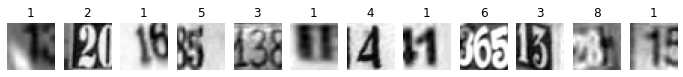

In [9]:
figure, ax = plt.subplots(1,12,figsize=(12,1)) # figsize is width, height
for i in range(12):
    index = np.random.randint(train_X.shape[0])
    ax[i].set_axis_off()
    ax[i].imshow(train_X[index,:,:,0], cmap="gray")
    ax[i].set_title(train_y[index,0])

In [10]:
# converting label 10 to label 0 since 10 represents the digit 0 for this dataset. This conversion also required for further training using sparse categorical cross-entropy with values from 0 to 9 
train_y = np.where(train_y == 10, 0, train_y)
test_y = np.where(test_y == 10, 0, test_y)
# print(np.unique(train_y))
# print(np.unique(test_y))

In [11]:
# function for creating a Convolutional Neural Network
def get_cnn_model(input_shape):
    model = Sequential([
        Conv2D(8, kernel_size=(3,3), padding="SAME" , input_shape=input_shape, activation="relu"),
        MaxPool2D((2,2)),
        Conv2D(8, kernel_size=(3,3), padding="SAME" , input_shape=input_shape, activation="relu"),
        MaxPool2D((2,2)),
        Flatten(),
        Dense(32, activation="relu"),
        BatchNormalization(),
        Dense(16, activation="relu"),
        Dropout(0.2),
        Dense(10, activation="softmax")
    ])
    return model

In [12]:
model_cnn = get_cnn_model((32,32,1))
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                1

In [13]:
# compiling the mode
model_cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]) # loss used is sparse_categorical_crossentropy since output labels are integers


In [14]:
# Creating callbacks to be used during training
cnn_model_checkpoint_path = "./model_checkpoints_best/cnn_checkpoint"
callback_checkpoint = ModelCheckpoint(filepath = cnn_model_checkpoint_path, 
                                      save_weights_only=True, monitor="val_accuracy" , 
                                      save_best_only=True, verbose=1 )
callback_early_stopping = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1)

In [15]:
# training the model 
history_cnn = model_cnn.fit(x=train_X , y=train_y, validation_split=0.15, 
                           callbacks=[callback_checkpoint, callback_early_stopping], verbose=2,
                           epochs = 30, batch_size=256)

Epoch 1/30

Epoch 00001: val_accuracy improved from -inf to 0.32260, saving model to ./model_checkpoints_best/cnn_checkpoint
244/244 - 1s - loss: 2.0140 - accuracy: 0.2928 - val_loss: 2.0880 - val_accuracy: 0.3226
Epoch 2/30

Epoch 00002: val_accuracy improved from 0.32260 to 0.59050, saving model to ./model_checkpoints_best/cnn_checkpoint
244/244 - 1s - loss: 1.4105 - accuracy: 0.5105 - val_loss: 1.2926 - val_accuracy: 0.5905
Epoch 3/30

Epoch 00003: val_accuracy improved from 0.59050 to 0.65939, saving model to ./model_checkpoints_best/cnn_checkpoint
244/244 - 1s - loss: 1.1123 - accuracy: 0.6151 - val_loss: 1.0208 - val_accuracy: 0.6594
Epoch 4/30

Epoch 00004: val_accuracy improved from 0.65939 to 0.72927, saving model to ./model_checkpoints_best/cnn_checkpoint
244/244 - 1s - loss: 0.9459 - accuracy: 0.6878 - val_loss: 0.8514 - val_accuracy: 0.7293
Epoch 5/30

Epoch 00005: val_accuracy improved from 0.72927 to 0.77405, saving model to ./model_checkpoints_best/cnn_checkpoint
244/244

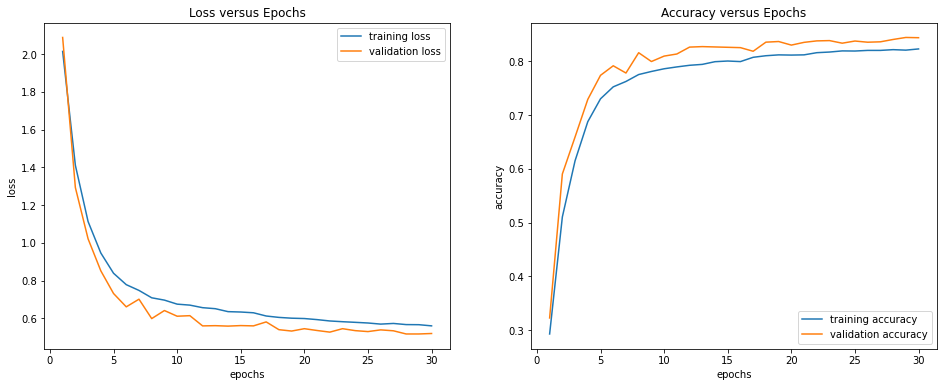

In [16]:
# Plots for loss versus epoch and accuracy versus epoch for train and validation sets
loss     = history_cnn.history["loss"]
val_loss = history_cnn.history["val_loss"]
accuracy = history_cnn.history["accuracy"]
val_accuracy = history_cnn.history["val_accuracy"]
epochs = np.arange(len(loss)) + 1

figure, axes = plt.subplots(1,2, figsize=(16,6))
axes[0].plot(epochs, loss, label="training loss")
axes[0].plot(epochs, val_loss, label="validation loss")
axes[0].set_xlabel("epochs")
axes[0].set_ylabel("loss")
axes[0].set_title("Loss versus Epochs")
axes[0].legend()

axes[1].plot(epochs, accuracy, label="training accuracy")
axes[1].plot(epochs, val_accuracy, label="validation accuracy")
axes[1].set_xlabel("epochs")
axes[1].set_ylabel("accuracy")
axes[1].set_title("Accuracy versus Epochs")
axes[1].legend()

In [17]:
# evaluate loss and accuracy on the test set
loss_test, accuracy_test = model_cnn.evaluate(test_X, test_y, verbose=0)
print("Loss {} , Accuracy {} on the test set with cnn model".format(loss_test, accuracy_test))

Loss 0.5830133557319641 , Accuracy 0.832744300365448 on the test set with cnn model


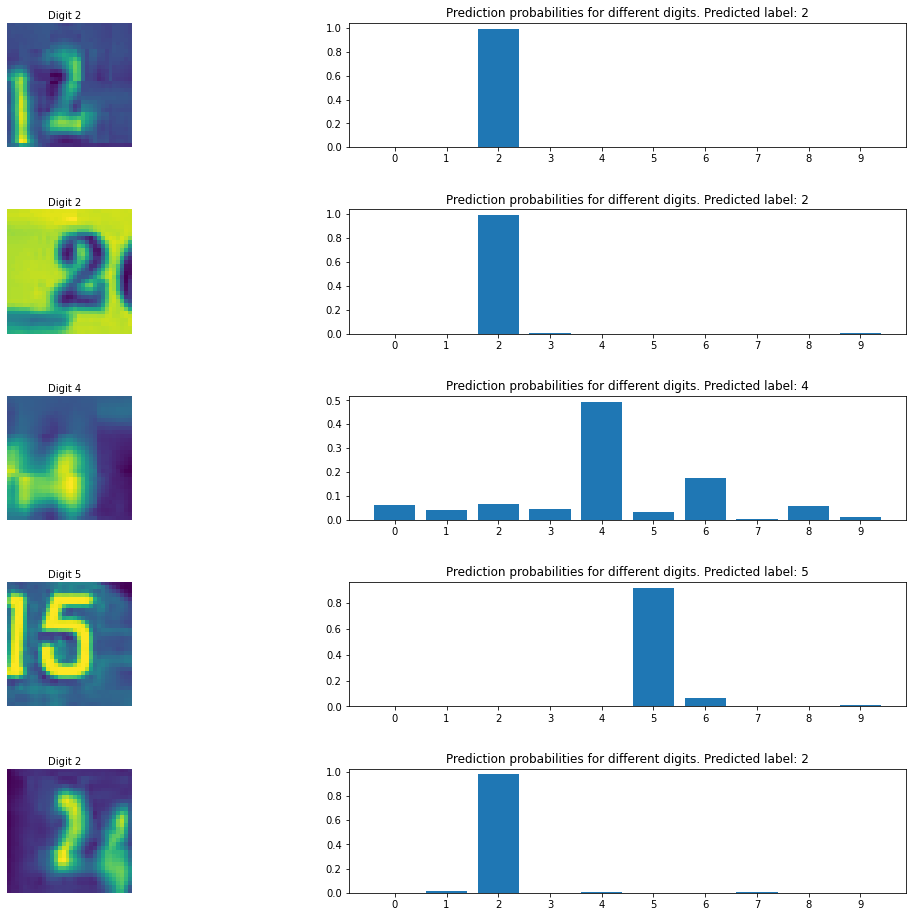

In [31]:
# Getting model predictions on sample images from the test set
num_test_images = test_X.shape[0]
idxs = np.random.choice(num_test_images,5)

random_test_images = test_X[idxs,...]
random_test_labels = test_y[idxs,...]
predictions_cnn    = model_cnn.predict(random_test_images)

figure, axes = plt.subplots(5, 2, figsize=(20,16))
for i, (img, label, preds_cnn) in enumerate(zip(random_test_images, random_test_labels, predictions_cnn)):
    axes[i,0].imshow(np.squeeze(img))
    axes[i,0].set_axis_off()
    axes[i,0].text(10,-1.5, f'Digit {label[0]}')
    axes[i,1].bar(np.arange(len(preds_cnn)), preds_cnn)
    axes[i,1].set_xticks(np.arange(len(preds_cnn)))
    axes[i,1].set_title(f"Prediction probabilities for different digits. Predicted label: {np.argmax(preds_cnn)}")
 
plt.subplots_adjust(wspace=0.001, hspace=0.5)
plt.show()